## Mean Normalization 

In [63]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [64]:
#!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -P datasets
#!tar xf datasets/cifar-10-python.tar.gz -C datasets

In [65]:
# The CIFAR-10 dataset consists of 32x32 labeled images which belong to 10 different classes

with open('datasets/cifar-10-batches-py/data_batch_1', 'rb') as input_file: 
    X = pickle.load(input_file, encoding='latin1')

In [66]:
X.keys()

dict_keys(['batch_label', 'labels', 'data', 'filenames'])

In [67]:
X = X['data']

In [68]:
X.shape # number_of_images, height * width * channels

(10000, 3072)

In [69]:
X = X.reshape((-1, 3, 32, 32))

X.shape # number_of_images, channels, height, width

(10000, 3, 32, 32)

In [70]:
X = X.transpose(0, 2, 3, 1) 

# transpose command moves the dimention around.
# The first channel is 0. The second channel is 1. And so on
# number_of_images, channels, height, width -> number_of_images, height, width, channels 

X.shape

(10000, 32, 32, 3)

In [71]:
X = X.reshape(-1, 3 * 32 * 32) 

X.shape

(10000, 3072)

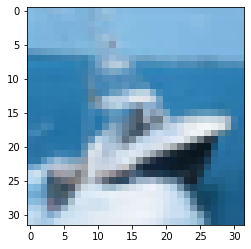

In [74]:
plt.imshow(X[8].reshape(32, 32, 3))

plt.show()

## Normalization
* zero-centre the data :this calculates the mean separately across pixels and colour channels
* divide by std

In [75]:
X = X - X.mean(axis=0)

In [76]:
X = X / np.std(X, axis=0) 

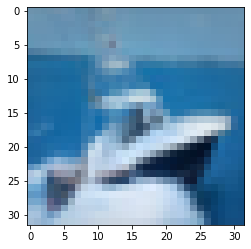

In [77]:
def show(i):
    i = i.reshape((32, 32, 3))

    m, M = i.min(), i.max()
    
    plt.imshow((i - m) / (M - m))
    plt.show()

show(X[8])

### (advanced) ZCA whitening
Whitening is a transformation of data in such a way that its covariance matrix Σ is the identity matrix. Hence whitening decorrelates features. It is used as a preprocessing method.  Principal component analysis (PCA) and Zero-phase component analysis (ZCA) are the two ways to do this.

* compute the covariance of the image data
* perform singular value decomposition (These steps take time)
* build the ZCA matrix
* transform the image data  

In [78]:
X_subset = X[:1000]

X_subset.shape

(1000, 3072)

In [79]:
cov = np.cov(X_subset, rowvar=True)   

In [80]:
cov.shape

(1000, 1000)

In [88]:
# Decompose matrix using Singular Value Decomposition which performs factor analysis
U, S, V = np.linalg.svd(cov)      

In [89]:
print(U.shape)
print(S.shape)
print(V.shape)

(1000, 1000)
(1000,)
(1000, 1000)


In [90]:
epsilon = 1e-5

# Calculating the principal components of the image features
# https://cbrnr.github.io/posts/whitening-pca-zca/

zca_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))

In [91]:
zca_matrix.shape

(1000, 1000)

In [92]:
# Multiply the principal components by the original matrix is whitening
zca = np.dot(zca_matrix, X_subset)   

In [93]:
zca.shape

(1000, 3072)

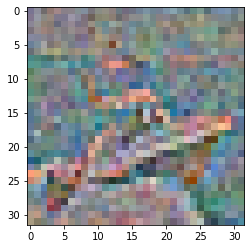

In [94]:
show(zca[8])

## Pre-processing in PyTorch

In [95]:
import torch
import torchvision
import torchvision.transforms as transforms

In [96]:
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'Enum',
 'F',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'List',
 'Normalize',
 'Optional',
 'PILToTensor',
 'Pad',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'Tensor',
 'ToPILImage',
 'ToTensor',
 'Tuple',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'math',
 'torch',
 'transforms']

In [97]:
# You can apply a list of many transformations

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

In [98]:
dataset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train', download=True, transform=transform)

Files already downloaded and verified


In [33]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/cifar10/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               ToTensor()
           )

In [116]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=16,
                                         shuffle=True, 
                                         num_workers=2)

### Viewing the images

In [117]:
images_batch, labels_batch = iter(dataloader).next()

In [118]:
images_batch.shape

torch.Size([16, 3, 256, 256])

In [119]:
labels_batch.shape

torch.Size([16])

In [120]:
labels_batch

tensor([1, 8, 2, 0, 4, 6, 0, 5, 1, 4, 7, 4, 9, 9, 3, 6])

In [121]:
img = torchvision.utils.make_grid(images_batch)

In [122]:
img.shape # attention: the first dimension is now the channels

torch.Size([3, 518, 2066])

In [123]:
img = np.transpose(img, (1, 2, 0))

In [124]:
img.shape

torch.Size([518, 2066, 3])

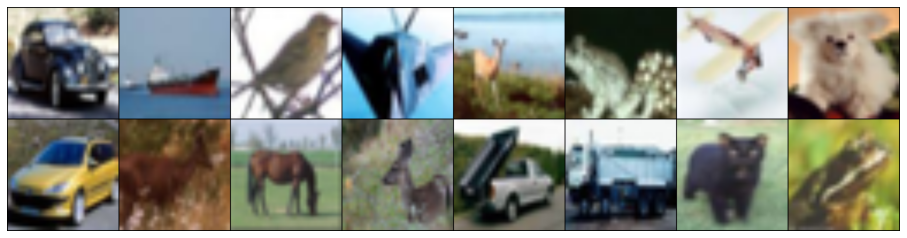

In [125]:
plt.figure (figsize = (16, 12))

plt.imshow(img)
plt.axis('off')
plt.show()

## Normalization

Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation

* Finding mean and std

In [133]:
pop_mean = []
pop_std = []

In [134]:
for i, data in enumerate(dataloader, 0): 
    # shape (batch_size, 3, height, width)
    numpy_image = data[0].numpy() # data[0]: images, data[1]: labels
    
    # shape (3,) # for each channel
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3)) # 0: batch, 2: height, 3: width 
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

In [135]:
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

In [136]:
pop_mean.shape, pop_std.shape # 3125 batches, 3 channels

((3125, 3), (3125, 3))

In [137]:
# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)

pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)

In [138]:
print(pop_mean)
print(pop_std)

[0.49159136 0.48234546 0.44671977]
[0.23831773 0.23487628 0.25258464]


### Applying transforms 

In [139]:
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(pop_mean, 
                                 pop_std)
            ])

In [140]:
trainset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/train', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [141]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

In [142]:
images_batch, labels_batch = iter(trainloader).next()

In [143]:
images_batch.shape

torch.Size([16, 3, 224, 224])

### Viewing the images

In [144]:
img = torchvision.utils.make_grid(images_batch)

img.shape

torch.Size([3, 454, 1810])

In [145]:
img = np.transpose(img, (1, 2, 0))

img.shape

torch.Size([454, 1810, 3])

In [146]:
m, M = img.min(), img.max()

m, M

(tensor(-2.0536), tensor(2.1905))

In [147]:
# Ensure floating point image RGB values must be in the 0..1 range.

img = (1/(abs(m) * M)) * img + 0.5 

In [148]:
img

tensor([[[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.1548, 0.2068, 0.2794],
         ...,
         [0.7950, 0.7969, 0.8661],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        ...,

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.2975, 0.3144, 0.3830],
         ...,
         [0.4511, 0.6485, 0.7488],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.

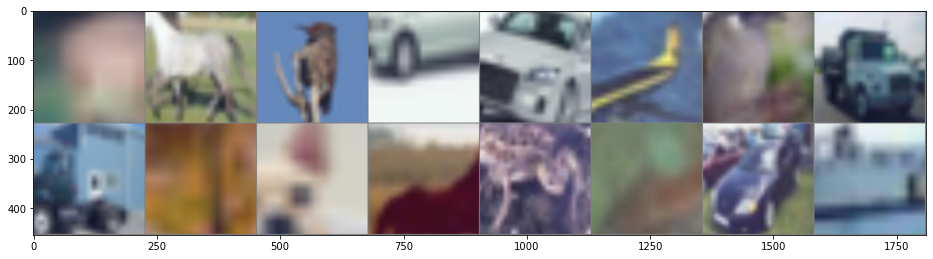

In [149]:
plt.figure (figsize = (16, 12))

plt.imshow(img)
plt.show()